### 训练模型

In [121]:
# 准备工作， 去前面一样
import numpy as np
import pandas as pd
import os

np.random.seed(42)

%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = ".."
CHAPTER_ID = "training_linear_models"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")


### 线性回归

关于线性回归参数的求解，可以使用标准方程，直接得到参数最优解。

$$\widehat{\theta}  = (X^{T} \cdot X)^{-1}\cdot X^{T}\cdot y$$    
使用https://www.codecogs.com/latex/eqneditor.php 编辑

In [122]:
X = 2 * np.random.rand(100, 1) #产生100 * 1的范围在0--1内的随机数。
y = 4 + 3 * X + np.random.rand(100, 1)

假设要求X，Y线性回归的参数，除去噪声的影响，参数为(3, 4)

Saving figure generated_data_plot


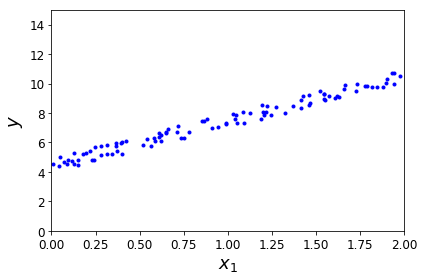

In [123]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize = 18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

In [124]:
# 因为有常数项的缘故， 因此添加常数的参数为1.
X_b = np.c_[np.ones((100, 1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [125]:
theta_best # 可以看得结果，常数项为4左右，参数为3左右

array([[4.51359766],
       [2.98323418]])

In [126]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  #添加常数项 1
y_predict = X_new_b.dot(theta_best)
y_predict 

array([[ 4.51359766],
       [10.48006601]])

Saving figure linear_model_predictions


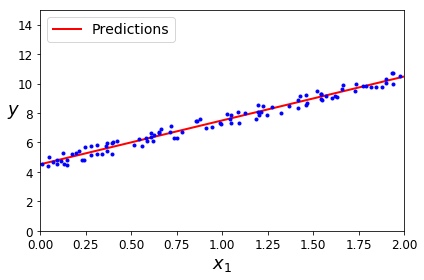

In [127]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0,  fontsize = 18)
plt.legend(loc="upper left", fontsize=14) #加上图例
plt.axis([0, 2, 0, 15])
save_fig("linear_model_predictions")
plt.show()

下面使用sklearn的线性回顾模型来做预测对比

In [128]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.51359766]), array([[2.98323418]]))

可以看到结果是一样的。LinearRegression 也是基于scipy.linalg.lstsq()， 因此也可以这样求解。

In [129]:
theta_best_svd, residutals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.51359766],
       [2.98323418]])

In [130]:
np.linalg.pinv(X_b).dot(y)

array([[4.51359766],
       [2.98323418]])

不过由于计算的复杂度过高，因此在特征较大时，一般都不使用方程求解。

### 使用梯度下降求解线性回归

对于线性回归来说，需要计算损失函数的偏导数。  
然后对  ${\theta}$ 做更新。   
这里不做公式推导和介绍。

In [131]:
eta = 0.1 # 学习速率
n_iterations = 1000
m = 100
theta = np.random.randn(2, 1) #随机初始化

for iteration in range(n_iterations):
    gradients = 2 / m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [132]:
theta

array([[4.51359766],
       [2.98323418]])

In [133]:
X_new_b.dot(theta)

array([[ 4.51359766],
       [10.48006601]])

In [134]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2 / m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title("$\eta={}$".format(eta), fontsize=16)


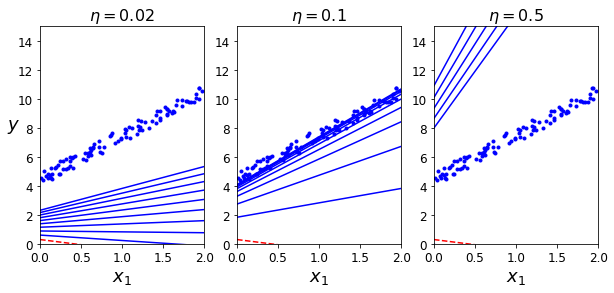

In [135]:
theta = np.random.randn(2, 1)  #随机初始化

plt.figure(figsize=(10, 4))
plt.subplot(131)
plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); 
plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); 
plot_gradient_descent(theta, eta=0.5)

可以看到不同的学习率对结果的影响，过小拟合过程会很慢，过大容易过拟合。  
为了寻找合适的学习率，可以使用网格搜索。  
另外一个参数是循环次数，这里可以采用当误差小于某一个值时， 结束循环。

### 随机梯度下降

上述的梯度下降最大的问题在于每次都是用全部数据集进行计算，因此计算速度很慢。而随机梯度下降每次随机选择一部分数据计算梯度进行更新。  
很显然可以加快运行速度，因此可以训练很大的数据集。  因此SGD可以算是out-of-core算法。
另外一个问题，由于随机性，下降方向不是沿着梯度(上下起伏)，而是曲折的降低，直到最小值。  
到最小值之后会继续反弹，永远不会稳定。所以一旦算法停止，最终的参数不一定是最优解。  

当损失函数不是特别规范时， 即有多个局部最优解， 随机梯度下降可以跳出局部最优解，因此有更好的机会求得全局最优解。  
由于这种特性，到达最优解是也不会停止计算。一种解决方式是逐渐减小学习率。这个过程叫做退火(simulated annealing)。  

In [136]:
theta_path_sgd = []
m = len(X_b)

Saving figure sdd_plot


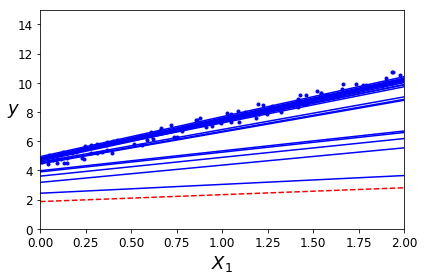

In [137]:
n_epochs = 50
t0, t1 = 5, 50

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:
            y_predict = X_new_b.dot(theta)
            style = "b-" if i > 0 else "r--"         
            plt.plot(X_new, y_predict, style)
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index + 1]
        yi = y[random_index:random_index + 1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)
        
plt.plot(X, y, "b.")
plt.xlabel("$X_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("sdd_plot")
plt.show()

In [138]:
theta

array([[4.51851544],
       [2.98246311]])

In [139]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=50, penalty=None, eta0=0.1,random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.1,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=50, n_iter=None, penalty=None,
       power_t=0.25, random_state=42, shuffle=True, tol=None, verbose=0,
       warm_start=False)

In [140]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.51388816]), array([2.98206789]))

### 小批量梯度下降

In [141]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2, 1)  #满足标准正态分布的随机值  2 * 1 维度

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i + minibatch_size]
        yi = y_shuffled[i:i + minibatch_size]
        gradients = 2 / minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)
    

In [142]:
theta

array([[4.47970445],
       [3.01436055]])

In [143]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

Saving figure gradient_descent_paths_plot


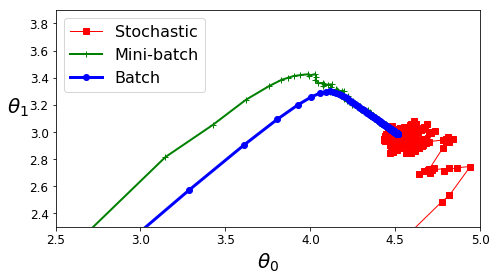

In [145]:
plt.figure(figsize=(7, 4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 5.0, 2.3, 3.9])
save_fig("gradient_descent_paths_plot")
plt.show()

In [146]:
### 多项式回归